In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchinfo import summary
from comet_ml import Experiment
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small
from torchvision.models import MobileNet_V3_Large_Weights as weights_large, MobileNet_V3_Small_Weights as weights_small
import torchvision.transforms as transforms

# Local imports
sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import delete_ds_store, plot_metrics, test, train, set_device, mean_std_finder, load_model
from CBAM_CAM import _CBAM
from MBNV3_2 import MBNV3Creator
from config import comet_token, project_name, workspace

# Setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": weights_small.IMAGENET1K_V1,
    "module": _CBAM,
    "module_alias": "CBAM_CAM",
    "data_path": "../data/faces_50/",
    "batch_size": 16,
    "img_size": 64,
    "num_classes": 50,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": set_device(),
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace),
    "load_model": False,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/pytorch-mbnv3-faces-50/34c6949de3d54356bec85c2fc6214fba



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.3860, 0.3119, 0.2690]), torch.tensor([0.2279, 0.2167, 0.2135])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=32, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


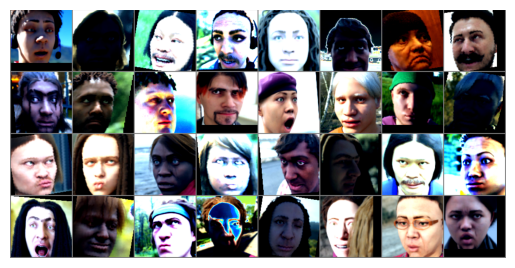

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model

model = load_model(model.build(), prms["model_save_path"]) if prms["load_model"] else model.build()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])

# log loss and optimizer
prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer})

9 SE blocks replaced with <class 'CBAM_CAM._CBAM'>
Weights of the inserted module layers initialized and weights trainable


In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                          [1, 3, 64, 64]       [1, 50]              --                   --                   --                   Partial
├─Sequential (features)                            [1, 3, 64, 64]       [1, 576, 2, 2]       --                   --                   --                   Partial
│    └─Conv2dNormActivation (0)                    [1, 3, 64, 64]       [1, 16, 32, 32]      --                   --                   --                   False
│    │    └─Conv2d (0)                             [1, 3, 64, 64]       [1, 16, 32, 32]      (432)                [3, 3]               442,368              False
│    │    └─BatchNorm2d (1)                        [1, 16, 32, 32]      [1, 16, 32, 32]      (32)                 --                   32                   False
│    │    └─Hardswis

  0%|          | 0/90 [00:00<?, ?it/s]/Users/leo/Desktop/Thesis/env/lib/python3.9/site-packages/torch/nn/functional.py:2101: UserWarning: The operator 'aten::hardswish_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  return torch._C._nn.hardswish_(input)
100%|██████████| 18/18 [00:03<00:00,  5.18it/s]


Epoch: 01 | Epoch Time: 0.0m 41s
	Train Loss: 3.530 | Train Acc: 15.19%
	 Val. Loss: 3.939 |  Val. Acc: 5.64%
Best Accuracy Achieved: 5.64% on epoch 01


100%|██████████| 18/18 [00:02<00:00,  8.34it/s]


Epoch: 02 | Epoch Time: 0.0m 24s
	Train Loss: 2.663 | Train Acc: 30.98%
	 Val. Loss: 1.967 |  Val. Acc: 46.55%
Best Accuracy Achieved: 46.55% on epoch 02


100%|██████████| 18/18 [00:02<00:00,  8.18it/s]


Epoch: 03 | Epoch Time: 0.0m 25s
	Train Loss: 1.843 | Train Acc: 50.25%
	 Val. Loss: 1.556 |  Val. Acc: 57.45%
Best Accuracy Achieved: 57.45% on epoch 03


100%|██████████| 18/18 [00:02<00:00,  8.08it/s]


Epoch: 04 | Epoch Time: 0.0m 23s
	Train Loss: 1.528 | Train Acc: 59.19%
	 Val. Loss: 1.432 |  Val. Acc: 60.00%
Best Accuracy Achieved: 60.00% on epoch 04


100%|██████████| 18/18 [00:02<00:00,  8.46it/s]


Epoch: 05 | Epoch Time: 0.0m 23s
	Train Loss: 1.315 | Train Acc: 64.00%
	 Val. Loss: 1.309 |  Val. Acc: 60.36%
Best Accuracy Achieved: 60.36% on epoch 05


100%|██████████| 18/18 [00:02<00:00,  8.82it/s]


Epoch: 06 | Epoch Time: 0.0m 22s
	Train Loss: 1.207 | Train Acc: 66.81%
	 Val. Loss: 1.307 |  Val. Acc: 62.55%
Best Accuracy Achieved: 62.55% on epoch 06


100%|██████████| 18/18 [00:02<00:00,  8.43it/s]


Epoch: 07 | Epoch Time: 0.0m 22s
	Train Loss: 1.049 | Train Acc: 71.68%
	 Val. Loss: 1.192 |  Val. Acc: 63.27%
Best Accuracy Achieved: 63.27% on epoch 07


100%|██████████| 18/18 [00:02<00:00,  8.90it/s]


Epoch: 08 | Epoch Time: 0.0m 22s
	Train Loss: 1.054 | Train Acc: 71.12%
	 Val. Loss: 1.175 |  Val. Acc: 65.82%
Best Accuracy Achieved: 65.82% on epoch 08


100%|██████████| 18/18 [00:01<00:00,  9.03it/s]


Epoch: 09 | Epoch Time: 0.0m 22s
	Train Loss: 1.003 | Train Acc: 72.70%
	 Val. Loss: 1.208 |  Val. Acc: 64.55%


100%|██████████| 18/18 [00:01<00:00,  9.05it/s]


Epoch: 10 | Epoch Time: 0.0m 21s
	Train Loss: 0.914 | Train Acc: 74.39%
	 Val. Loss: 1.186 |  Val. Acc: 66.00%
Best Accuracy Achieved: 66.00% on epoch 10


100%|██████████| 18/18 [00:02<00:00,  7.33it/s]


Epoch: 11 | Epoch Time: 0.0m 22s
	Train Loss: 0.818 | Train Acc: 77.68%
	 Val. Loss: 1.103 |  Val. Acc: 67.64%
Best Accuracy Achieved: 67.64% on epoch 11


100%|██████████| 18/18 [00:02<00:00,  8.91it/s]


Epoch: 12 | Epoch Time: 0.0m 21s
	Train Loss: 0.813 | Train Acc: 76.91%
	 Val. Loss: 1.041 |  Val. Acc: 71.45%
Best Accuracy Achieved: 71.45% on epoch 12


100%|██████████| 18/18 [00:02<00:00,  8.75it/s]


Epoch: 13 | Epoch Time: 0.0m 21s
	Train Loss: 0.777 | Train Acc: 78.28%
	 Val. Loss: 1.122 |  Val. Acc: 67.82%


100%|██████████| 18/18 [00:02<00:00,  8.80it/s]


Epoch: 14 | Epoch Time: 0.0m 24s
	Train Loss: 0.734 | Train Acc: 79.44%
	 Val. Loss: 1.072 |  Val. Acc: 70.00%


100%|██████████| 18/18 [00:02<00:00,  8.75it/s]


Epoch: 15 | Epoch Time: 0.0m 23s
	Train Loss: 0.765 | Train Acc: 78.81%
	 Val. Loss: 1.073 |  Val. Acc: 69.27%


100%|██████████| 18/18 [00:02<00:00,  7.87it/s]


Epoch: 16 | Epoch Time: 0.0m 23s
	Train Loss: 0.653 | Train Acc: 81.16%
	 Val. Loss: 1.157 |  Val. Acc: 66.91%


100%|██████████| 18/18 [00:02<00:00,  8.42it/s]


Epoch: 17 | Epoch Time: 0.0m 23s
	Train Loss: 0.640 | Train Acc: 82.49%
	 Val. Loss: 1.112 |  Val. Acc: 67.27%


100%|██████████| 18/18 [00:02<00:00,  8.26it/s]


Epoch: 18 | Epoch Time: 0.0m 23s
	Train Loss: 0.658 | Train Acc: 81.61%
	 Val. Loss: 1.131 |  Val. Acc: 66.55%


100%|██████████| 18/18 [00:02<00:00,  8.82it/s]


Epoch: 19 | Epoch Time: 0.0m 22s
	Train Loss: 0.659 | Train Acc: 81.33%
	 Val. Loss: 1.043 |  Val. Acc: 71.64%
Best Accuracy Achieved: 71.64% on epoch 19


100%|██████████| 18/18 [00:02<00:00,  8.58it/s]


Epoch: 20 | Epoch Time: 0.0m 22s
	Train Loss: 0.601 | Train Acc: 83.23%
	 Val. Loss: 0.967 |  Val. Acc: 72.18%
Best Accuracy Achieved: 72.18% on epoch 20


100%|██████████| 18/18 [00:01<00:00,  9.27it/s]


Epoch: 21 | Epoch Time: 0.0m 23s
	Train Loss: 0.641 | Train Acc: 82.67%
	 Val. Loss: 1.092 |  Val. Acc: 69.45%


100%|██████████| 18/18 [00:02<00:00,  8.88it/s]


Epoch: 22 | Epoch Time: 0.0m 22s
	Train Loss: 0.587 | Train Acc: 83.37%
	 Val. Loss: 0.980 |  Val. Acc: 69.82%


100%|██████████| 18/18 [00:02<00:00,  8.62it/s]


Epoch: 23 | Epoch Time: 0.0m 22s
	Train Loss: 0.525 | Train Acc: 85.58%
	 Val. Loss: 0.970 |  Val. Acc: 70.18%


100%|██████████| 18/18 [00:01<00:00,  9.33it/s]


Epoch: 24 | Epoch Time: 0.0m 21s
	Train Loss: 0.569 | Train Acc: 84.60%
	 Val. Loss: 1.070 |  Val. Acc: 68.00%


100%|██████████| 18/18 [00:01<00:00,  9.42it/s]


Epoch: 25 | Epoch Time: 0.0m 21s
	Train Loss: 0.556 | Train Acc: 84.67%
	 Val. Loss: 1.094 |  Val. Acc: 69.09%


100%|██████████| 18/18 [00:01<00:00,  9.40it/s]


Epoch: 26 | Epoch Time: 0.0m 20s
	Train Loss: 0.563 | Train Acc: 83.54%
	 Val. Loss: 1.039 |  Val. Acc: 69.82%


100%|██████████| 18/18 [00:01<00:00,  9.34it/s]


Epoch: 27 | Epoch Time: 0.0m 21s
	Train Loss: 0.535 | Train Acc: 84.70%
	 Val. Loss: 1.074 |  Val. Acc: 70.36%


100%|██████████| 18/18 [00:01<00:00,  9.29it/s]


Epoch: 28 | Epoch Time: 0.0m 21s
	Train Loss: 0.517 | Train Acc: 85.23%
	 Val. Loss: 1.003 |  Val. Acc: 69.82%


100%|██████████| 18/18 [00:02<00:00,  8.64it/s]


Epoch: 29 | Epoch Time: 0.0m 21s
	Train Loss: 0.521 | Train Acc: 85.19%
	 Val. Loss: 1.081 |  Val. Acc: 69.45%


100%|██████████| 18/18 [00:01<00:00,  9.24it/s]


Epoch: 30 | Epoch Time: 0.0m 22s
	Train Loss: 0.480 | Train Acc: 85.82%
	 Val. Loss: 1.066 |  Val. Acc: 68.00%


100%|██████████| 18/18 [00:01<00:00,  9.26it/s]


Epoch: 31 | Epoch Time: 0.0m 21s
	Train Loss: 0.510 | Train Acc: 85.65%
	 Val. Loss: 0.988 |  Val. Acc: 71.27%


100%|██████████| 18/18 [00:01<00:00,  9.37it/s]


Epoch: 32 | Epoch Time: 0.0m 21s
	Train Loss: 0.488 | Train Acc: 85.75%
	 Val. Loss: 1.005 |  Val. Acc: 71.09%


100%|██████████| 18/18 [00:01<00:00,  9.35it/s]


Epoch: 33 | Epoch Time: 0.0m 21s
	Train Loss: 0.491 | Train Acc: 86.04%
	 Val. Loss: 1.001 |  Val. Acc: 71.27%


100%|██████████| 18/18 [00:02<00:00,  8.26it/s]


Epoch: 34 | Epoch Time: 0.0m 22s
	Train Loss: 0.509 | Train Acc: 85.89%
	 Val. Loss: 0.967 |  Val. Acc: 72.73%
Best Accuracy Achieved: 72.73% on epoch 34


100%|██████████| 18/18 [00:02<00:00,  8.85it/s]


Epoch: 35 | Epoch Time: 0.0m 22s
	Train Loss: 0.491 | Train Acc: 86.25%
	 Val. Loss: 1.027 |  Val. Acc: 70.91%


100%|██████████| 18/18 [00:01<00:00,  9.51it/s]


Epoch: 36 | Epoch Time: 0.0m 21s
	Train Loss: 0.513 | Train Acc: 85.23%
	 Val. Loss: 0.937 |  Val. Acc: 72.73%


100%|██████████| 18/18 [00:02<00:00,  8.66it/s]


Epoch: 37 | Epoch Time: 0.0m 21s
	Train Loss: 0.459 | Train Acc: 87.19%
	 Val. Loss: 0.942 |  Val. Acc: 72.00%


100%|██████████| 18/18 [00:01<00:00,  9.31it/s]


Epoch: 38 | Epoch Time: 0.0m 22s
	Train Loss: 0.452 | Train Acc: 86.95%
	 Val. Loss: 0.965 |  Val. Acc: 72.73%


100%|██████████| 18/18 [00:02<00:00,  8.97it/s]


Epoch: 39 | Epoch Time: 0.0m 21s
	Train Loss: 0.478 | Train Acc: 86.98%
	 Val. Loss: 0.962 |  Val. Acc: 72.18%


100%|██████████| 18/18 [00:02<00:00,  9.00it/s]


Epoch: 40 | Epoch Time: 0.0m 21s
	Train Loss: 0.424 | Train Acc: 87.93%
	 Val. Loss: 0.955 |  Val. Acc: 73.64%
Best Accuracy Achieved: 73.64% on epoch 40


100%|██████████| 18/18 [00:01<00:00,  9.34it/s]


Epoch: 41 | Epoch Time: 0.0m 21s
	Train Loss: 0.434 | Train Acc: 87.68%
	 Val. Loss: 0.926 |  Val. Acc: 74.73%
Best Accuracy Achieved: 74.73% on epoch 41


100%|██████████| 18/18 [00:01<00:00,  9.31it/s]


Epoch: 42 | Epoch Time: 0.0m 21s
	Train Loss: 0.436 | Train Acc: 87.40%
	 Val. Loss: 1.024 |  Val. Acc: 72.55%


100%|██████████| 18/18 [00:01<00:00,  9.14it/s]


Epoch: 43 | Epoch Time: 0.0m 21s
	Train Loss: 0.451 | Train Acc: 86.81%
	 Val. Loss: 1.031 |  Val. Acc: 72.55%


100%|██████████| 18/18 [00:01<00:00,  9.08it/s]


Epoch: 44 | Epoch Time: 0.0m 21s
	Train Loss: 0.429 | Train Acc: 88.18%
	 Val. Loss: 0.929 |  Val. Acc: 73.64%


100%|██████████| 18/18 [00:01<00:00,  9.08it/s]


Epoch: 45 | Epoch Time: 0.0m 21s
	Train Loss: 0.444 | Train Acc: 87.61%
	 Val. Loss: 0.948 |  Val. Acc: 73.45%


100%|██████████| 18/18 [00:01<00:00,  9.03it/s]


Epoch: 46 | Epoch Time: 0.0m 21s
	Train Loss: 0.409 | Train Acc: 88.49%
	 Val. Loss: 0.984 |  Val. Acc: 72.36%


100%|██████████| 18/18 [00:02<00:00,  8.95it/s]


Epoch: 47 | Epoch Time: 0.0m 21s
	Train Loss: 0.439 | Train Acc: 87.68%
	 Val. Loss: 0.926 |  Val. Acc: 73.45%


100%|██████████| 18/18 [00:01<00:00,  9.02it/s]


Epoch: 48 | Epoch Time: 0.0m 21s
	Train Loss: 0.395 | Train Acc: 89.23%
	 Val. Loss: 0.960 |  Val. Acc: 73.27%


100%|██████████| 18/18 [00:01<00:00,  9.16it/s]


Epoch: 49 | Epoch Time: 0.0m 21s
	Train Loss: 0.421 | Train Acc: 88.35%
	 Val. Loss: 1.068 |  Val. Acc: 70.18%


100%|██████████| 18/18 [00:01<00:00,  9.20it/s]


Epoch: 50 | Epoch Time: 0.0m 21s
	Train Loss: 0.420 | Train Acc: 87.96%
	 Val. Loss: 1.000 |  Val. Acc: 72.00%


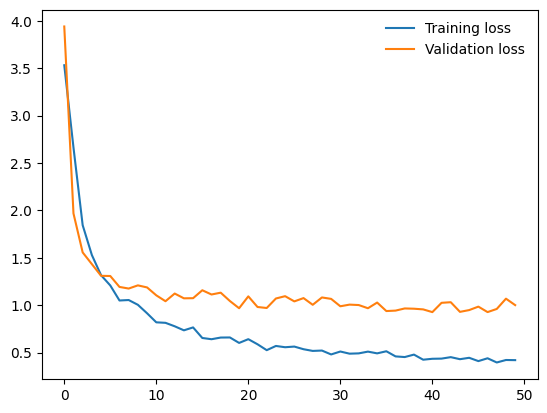

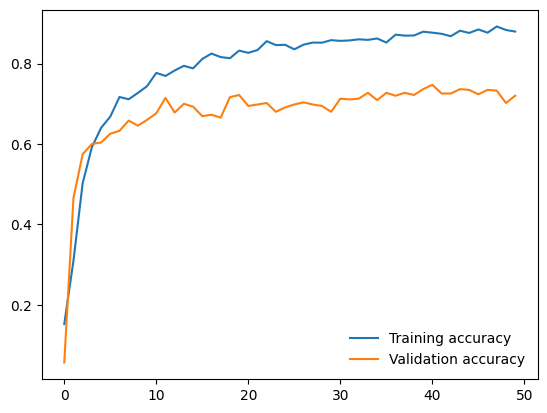

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, hyper_params = prms, verbose = 2, experiment = prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/pytorch-mbnv3-faces-50/34c6949de3d54356bec85c2fc6214fba
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.008248070478439331
COMET INFO:     test_accuracy   : 0.7199999690055847
COMET INFO:     test_loss       : 0.99457772731781
COMET INFO:     train_acc [50]  : (0.1519298255443573, 0.8922807574272156)
COMET INFO:     train_loss [50] : (0.394881498877678, 3.530171745032595)
COMET INFO:     val_acc [50]    : (0.05636363849043846, 0.7472727298736572)
COMET INFO:     val_loss [50]   : (0.9260732839730653, 3.9390497675808995)
COMET INFO:   Parameters:
COMET INFO:     backbone        : <function mobilenet_v3_small at 0x16cb3e040>
COMET INFO:     batch_size      : 16
COMET INFO:     data_path       : ../da

Test loss: 0.995.. 
Test accuracy: 0.720
Test Time: 0.0m 1s 649ms


COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: torch. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


(0.99457772731781, tensor(0.7200, device='mps:0'))